In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as py
from scipy import stats
!pip install pmdarima
from pmdarima.utils import tsdisplay
from pmdarima.arima import auto_arima
!pip3 install arch
import arch.data.default
from arch.unitroot import ADF
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import date

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 10.7 MB/s eta 0:00:00


In [ ]:
#ticket_01 = '^NDX'
#ticket_02 = '^VIX'
ticket_02 = 'DOGE-USD'
#ticket_02 = 'SHIB-USD'
#ticket_01 = 'GC=F' #ouro
#ticket_01 = 'DX-Y.NYB' #DXY
#ticket_01 = 'ZS=F' #soja
ticket_01 = 'BTC-USD'
#ticket_02 = 'BRL=X'
#ticket_02 = 'TURBO-USD'
data_inicio = '2024-09-18'
data_fim    = pd.to_datetime("today").strftime('%Y-%m-%d')
dados_01 = yf.download(ticket_01, start=data_inicio, end=data_fim)
dados_02 = yf.download(ticket_02, start=data_inicio, end=data_fim )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


##Ativo 01

In [ ]:
dados_01['Return'] = np.log(dados_01['Close'] / dados_01['Close'].shift(1))
dados_01 = dados_01.dropna()
#tsdisplay(dados_01['Adj Close'])
#tsdisplay(dados_01['Return'])
dados_01.tail()

Price,Close,High,Low,Open,Volume,Return
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,
Date,,,,,,
2025-01-07,96922.703125,102712.484375,96132.875000,102248.851562,58685738547,-0.051824
2025-01-08,95043.523438,97258.320312,92525.843750,96924.164062,63875859171,-0.019579
2025-01-09,92484.039062,95349.718750,91220.843750,95043.484375,62777261693,-0.027299
2025-01-10,94701.453125,95770.609375,92250.093750,92494.492188,62058693684,0.023693
2025-01-11,94566.593750,94977.687500,93840.046875,94700.835938,18860894100,-0.001425


In [ ]:
# Calcular o retorno diário
returns_01 = dados_01['Return'].dropna()

# Definir o nível de confiança (por exemplo, 95% de confiança)
confidence_level = 0.95

# Calcular o VaR no nível de confiança especificado
var = np.percentile(returns_01, (1 - confidence_level) * 100)

# Exibir o VaR como uma perda percentual
print(f"O VaR no nível de confiança de {confidence_level * 100}% para {ticket_01} é aproximadamente {var * 100:.2f}%")


O VaR no nível de confiança de 95.0% para BTC-USD é aproximadamente -3.64%


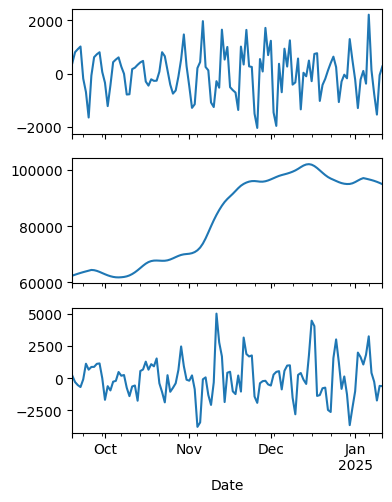

In [ ]:
# Decmposição STL
dados_01 = dados_01.asfreq('D')
dados_01['Adj Close'] = dados_01['Close'].interpolate()
stl_dados_01 = sm.tsa.STL(dados_01['Adj Close'])
stl_dados_01_res = stl_dados_01.fit()
fig, axes = py.subplots(nrows=3, sharex=True, figsize=(4, 5.5))
stl_dados_01_res.seasonal.plot(ax=axes[0])
stl_dados_01_res.trend.plot(ax=axes[1])
stl_dados_01_res.resid.plot(ax=axes[2])
#plot_seasonal_decomp(stl_dados_01_res.trend, stl_dados_01_res.seasonal, stl_dados_01_res.resid, "STL")
dados_01_ns = stl_dados_01_res.trend+stl_dados_01_res.resid

In [ ]:
# Teste de Dickey-Fuller aumentado com drift+trend
adf_dados_01_trend = adfuller(dados_01['Adj Close'], regression='ct')
adf_dados_01_trend
print(f'ADF Statistic: {adf_dados_01_trend[0]}')
print(f'p-value: {adf_dados_01_trend[1]}')
for key, value in adf_dados_01_trend[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.3055260140548488
p-value: 0.8865555779451962
Critial Values:
   1%, -4.0404611509884285
Critial Values:
   5%, -3.449728197718056
Critial Values:
   10%, -3.1500478236218434


In [ ]:
# Vamos tomar a primeira diferença da série a analisar o resultado
dif_dados_01 = dados_01['Adj Close'].diff().dropna()
#tsdisplay(dif_dados_01)

In [ ]:
# Teste de Dickey-Fuller aumentado com drift+trend
adf_dif_dados_01_trend = adfuller(dif_dados_01, regression='ct')
adf_dif_dados_01_trend
print(f'ADF Statistic: {adf_dif_dados_01_trend[0]}')
print(f'p-value: {adf_dif_dados_01_trend[1]}')
for key, value in adf_dif_dados_01_trend[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.226736045451213
p-value: 7.716732548849837e-16
Critial Values:
   1%, -4.0412052347395555
Critial Values:
   5%, -3.450082195146292
Critial Values:
   10%, -3.15025431146506


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2033.055, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2034.885, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2036.843, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2038.855, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2034.909, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2036.870, Time=0.58 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2038.758, Time=1.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2040.775, Time=0.17 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2036.717, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2038.679, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2038.557, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2040.496, Time=0.31 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 5.891 seconds
intercept    2.785521e+02
sigma2       3.143499e+06
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1015.919
Date:                Mon, 13 Jan 2025   AIC                           2033.839
Time:                        04:29:11   BIC                           2036.575
Sample:                    09-19-2024   HQIC                          2034.949
                         - 01-11-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma

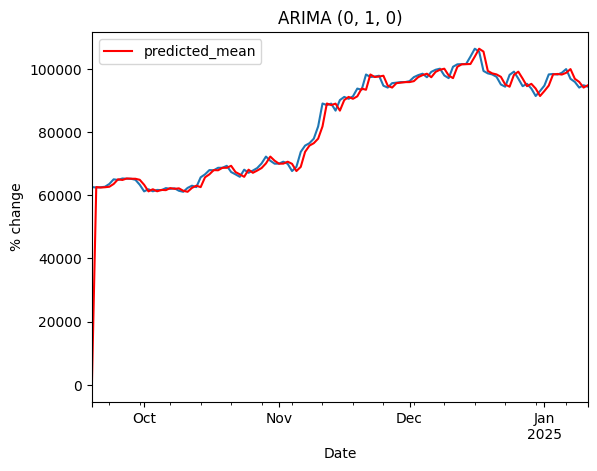

In [ ]:
#Auto Arima
AUTO_ARIMA = auto_arima(dados_01_ns,
                       start_p=1, start_q=1,
                       max_p=3, max_q=3,
                       seasonal=False,
                       d=1,
                       trace=True,
                       error_action='trace',
                       suppress_warnings=True,
                       stepwise=False)

print(AUTO_ARIMA.params())

best_model = AUTO_ARIMA
best_order = best_model.order

# Melhor modelo ARIMA(best_order)
BEST_ARIMA_adf_dados_01_ns = ARIMA(dados_01_ns, order=(best_order))
res_BEST_ARIMA_adf_dados_01_ns = BEST_ARIMA_adf_dados_01_ns.fit()
print(res_BEST_ARIMA_adf_dados_01_ns.summary())
BEST_ARIMA_adf_dados_01_ns_predict = pd.DataFrame(res_BEST_ARIMA_adf_dados_01_ns.predict())
fig, ax = py.subplots(1, 1)
dados_01_ns.plot(ax=ax)
BEST_ARIMA_adf_dados_01_ns_predict.plot(ax=ax,color='red')
py.ylabel("% change"); py.title('ARIMA '+str(best_order));
py.show()

     lb_stat  lb_pvalue
10  0.454273   0.999996


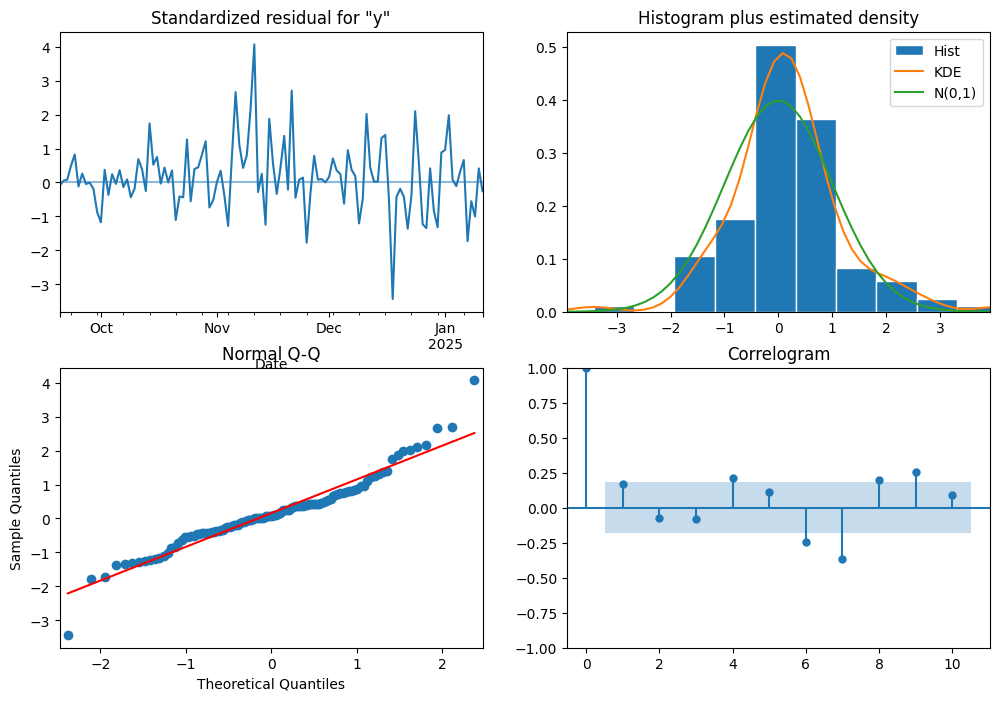

In [ ]:
# Analise dos resíduos
AUX = acorr_ljungbox(res_BEST_ARIMA_adf_dados_01_ns.resid, lags=[10])
res_BEST_ARIMA_adf_dados_01_ns.plot_diagnostics(figsize=(12,8))
print(AUX)
py.show()

In [ ]:
indice_10_frente_temp = pd.date_range(dados_01_ns.index[-1], freq="D", periods = 10+1) #Índice temporal para as previsões
indice_10_frente = indice_10_frente_temp[1:]
fcast_BEST_ARIMA_dados_01 = res_BEST_ARIMA_adf_dados_01_ns.get_forecast(10)
fcast_BEST_ARIMA_dados_01_mean = fcast_BEST_ARIMA_dados_01.summary_frame(alpha=0.05)['mean']
fcast_BEST_ARIMA_dados_01_low = fcast_BEST_ARIMA_dados_01.summary_frame(alpha=0.05)['mean_ci_lower']
fcast_BEST_ARIMA_dados_01_up = fcast_BEST_ARIMA_dados_01.summary_frame(alpha=0.05)['mean_ci_upper']
fcast_BEST_ARIMA_dados_01_mean = fcast_BEST_ARIMA_dados_01_mean.rename('ARIMA Forecast ' + str(best_order))

Forecast ARMA  (0, 1, 0) :
 y                   mean      mean_se  mean_ci_lower  mean_ci_upper
2025-01-12  94302.467288  1786.919351   90800.169716   97804.764859
2025-01-13  94302.467288  2527.085581   89349.470563   99255.464012
2025-01-14  94302.467288  3095.035105   88236.309951  100368.624624
2025-01-15  94302.467288  3573.838702   87297.872145  101307.062430
2025-01-16  94302.467288  3995.673139   86471.091841  102133.842734
2025-01-17  94302.467288  4377.040621   85723.625311  102881.309264
2025-01-18  94302.467288  4727.744216   85036.258897  103568.675678
2025-01-19  94302.467288  5054.171162   84396.473838  104208.460737
2025-01-20  94302.467288  5360.758053   83795.574574  104809.360001
2025-01-21  94302.467288  5650.735144   83227.229919  105377.704656 



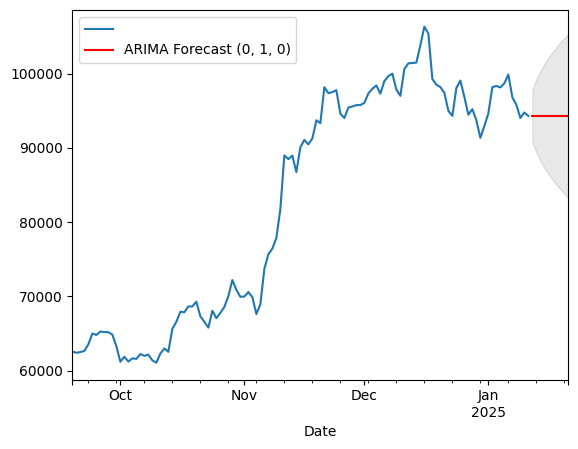

In [ ]:
## Imprime as previsões
print(f'Forecast ARMA ',best_order, ':\n',fcast_BEST_ARIMA_dados_01.summary_frame(alpha=0.05),'\n')

## Gráfico das previsões
fig_, ax_ = py.subplots(1, 1)
dados_01_ns.plot(ax=ax_, legend=True)
fcast_BEST_ARIMA_dados_01_mean.plot(ax=ax_,color='red', legend=True)
ax_.fill_between(indice_10_frente, fcast_BEST_ARIMA_dados_01_low, fcast_BEST_ARIMA_dados_01_up, color='k',alpha=.09);
py.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -265.673
Distribution:                  Normal   AIC:                           539.346
Method:            Maximum Likelihood   BIC:                           550.326
                                        No. Observations:                  115
Date:                Mon, Jan 13 2025   Df Residuals:                      114
Time:                        04:29:13   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.3741      0.221      1.689  9.117e-02 [-5.99

,Return
Date,
2025-01-08 00:00:00,-0.019579
2025-01-09 00:00:00,-0.027299
2025-01-10 00:00:00,0.023693
2025-01-11 00:00:00,-0.001425
"VolGARCH(1,1)",Date 2024-09-19 0.019304 2024-09-20 0.01...


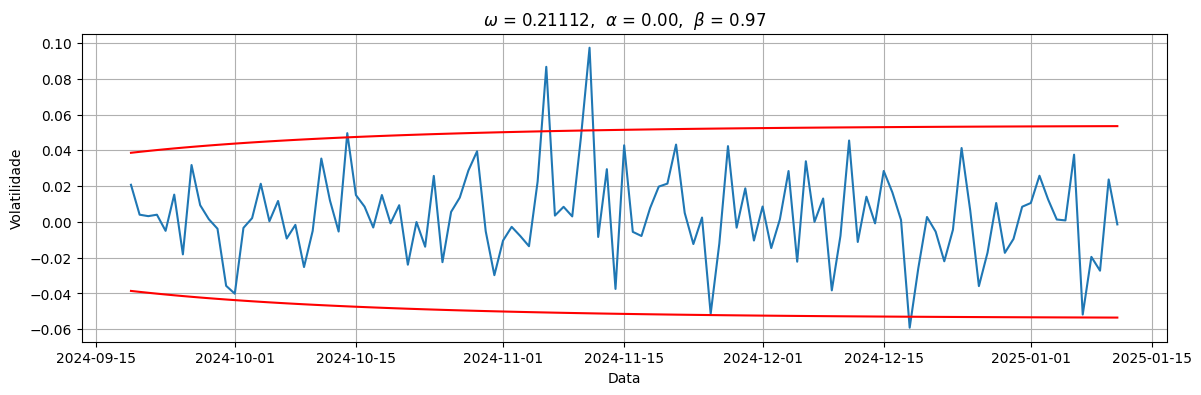

In [ ]:
#GARCH (1,1)
from arch import arch_model

dados = dados_01['Return'].dropna()

garch_1_1 = arch_model(100*dados, p=1, q=1, mean='constant', vol='GARCH', dist='normal')
garch_1_1_results = garch_1_1.fit(update_freq=0, disp=False)


print(garch_1_1_results.summary())
alpha = garch_1_1_results.params['alpha[1]']
beta  = garch_1_1_results.params['beta[1]']
omega = garch_1_1_results.params['omega']
py.figure(figsize=(14, 4))
py.plot(dados, label='Retorno')
py.plot( 2*garch_1_1_results.conditional_volatility/100, 'r', label='$\pm 2\sigma$')
py.plot(-2*garch_1_1_results.conditional_volatility/100, 'r')

py.title('$\omega$ = {:.5f},  $\\alpha$ = {:.2f},  $\\beta$ = {:.2f}'.format(omega, alpha, beta))
py.grid(True)
py.xlabel('Data')
py.ylabel('Volatilidade')
dados['VolGARCH(1,1)'] = garch_1_1_results.conditional_volatility/100
print(dados['VolGARCH(1,1)'])
dados.tail()

In [ ]:
dados.tail(100)

,Return
Date,
2024-10-05 00:00:00,0.000362
2024-10-06 00:00:00,0.011673
2024-10-07 00:00:00,-0.009313
2024-10-08 00:00:00,-0.001684
2024-10-09 00:00:00,-0.025261
...,...
2025-01-08 00:00:00,-0.019579
2025-01-09 00:00:00,-0.027299
2025-01-10 00:00:00,0.023693


<bound method NDFrame.head of                    0
time                
2025-01-12  0.026987
2025-01-13  0.026987
2025-01-14  0.026987
2025-01-15  0.026987
2025-01-16  0.026987
...              ...
2025-07-26  0.026987
2025-07-27  0.026987
2025-07-28  0.026987
2025-07-29  0.026987
2025-07-30  0.026987

[200 rows x 1 columns]>


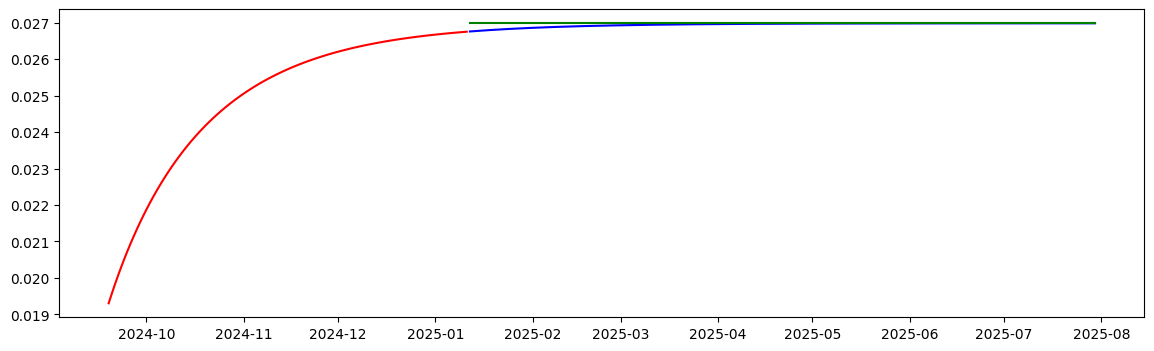

In [ ]:
#GARCH(1,1)

vol_garch_1_1 = garch_1_1_results.conditional_volatility/100
forecast_garch_1_1 = garch_1_1_results.forecast(horizon=200, reindex=False)
garch_1_1_vol_forecast_np = np.sqrt(forecast_garch_1_1.variance.values)/100
garch_1_1_vol_forecast = pd.DataFrame(np.transpose(garch_1_1_vol_forecast_np))
py.figure(figsize=(14, 4))
py.plot( vol_garch_1_1, 'r')
idx_200_frente_temp = pd.date_range(vol_garch_1_1.index[-1], freq="D", periods = 200+1) #Índice temporal para as previsões
idx_200_frente = idx_200_frente_temp[1:]
garch_1_1_vol_forecast['time'] = idx_200_frente
garch_1_1_vol_forecast = garch_1_1_vol_forecast.set_index('time') #Cría índice temporal
py.plot(garch_1_1_vol_forecast, 'b')
alpha = garch_1_1_results.params['alpha[1]']
beta  = garch_1_1_results.params['beta[1]']
omega = garch_1_1_results.params['omega']
var_garch_1_1= omega/(1-(alpha + beta))
std_garch_1_1 = pd.DataFrame(np.repeat(np.sqrt(var_garch_1_1)/100,200))
std_garch_1_1['time'] = idx_200_frente
std_garch_1_1 = std_garch_1_1.set_index('time') #Cría índice temporal
py.plot(std_garch_1_1, 'g')
print(std_garch_1_1.head)

In [ ]:
#######################################################################################################################################################################################################################################################

In [ ]:
#######################################################################################################################################################################################################################################################

##Ativo 02

In [ ]:
dados_02['Return'] = np.log(dados_02['Close'] / dados_02['Close'].shift(1))
dados_02 = dados_02.dropna()
#tsdisplay(dados_02['Adj Close'])
#tsdisplay(dados_02['Return'])
dados_02.tail()

Price,Close,High,Low,Open,Volume,Return
Ticker,DOGE-USD,DOGE-USD,DOGE-USD,DOGE-USD,DOGE-USD,
Date,,,,,,
2025-01-07,0.348437,0.397808,0.348422,0.387952,5280516863,-0.107437
2025-01-08,0.342248,0.355111,0.326810,0.348436,4416730765,-0.017922
2025-01-09,0.320912,0.346286,0.315103,0.342247,3614560190,-0.064369
2025-01-10,0.333981,0.338534,0.320891,0.320909,3222794655,0.039917
2025-01-11,0.340955,0.347811,0.330075,0.333979,1461005907,0.020666


In [ ]:
# Calcular o retorno diário
returns_02 = dados_02['Return'].dropna()

# Definir o nível de confiança (por exemplo, 95% de confiança)
confidence_level = 0.95

# Calcular o VaR no nível de confiança especificado
var = np.percentile(returns_02, (1 - confidence_level) * 100)

# Exibir o VaR como uma perda percentual
print(f"O VaR no nível de confiança de {confidence_level * 100}% para {ticket_02} é aproximadamente {var * 100:.2f}%")


O VaR no nível de confiança de 95.0% para DOGE-USD é aproximadamente -8.67%


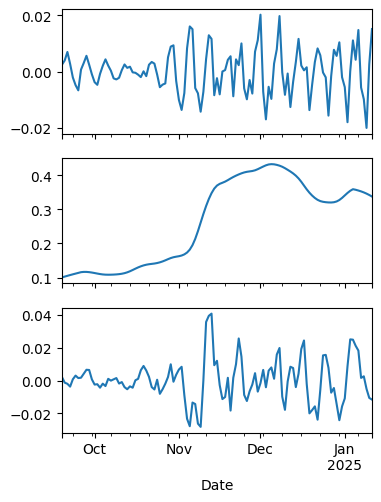

In [ ]:
# Decmposição STL
dados_02 = dados_02.asfreq('D')
dados_02['Adj Close'] = dados_02['Close'].interpolate()
stl_dados_02 = sm.tsa.STL(dados_02['Adj Close'])
stl_dados_02_res = stl_dados_02.fit()
fig, axes = py.subplots(nrows=3, sharex=True, figsize=(4, 5.5))
stl_dados_02_res.seasonal.plot(ax=axes[0])
stl_dados_02_res.trend.plot(ax=axes[1])
stl_dados_02_res.resid.plot(ax=axes[2])
#plot_seasonal_decomp(stl_dados_02_res.trend, stl_dados_02_res.seasonal, stl_dados_02_res.resid, "STL")
dados_02_ns = stl_dados_02_res.trend+stl_dados_02_res.resid

In [ ]:
# Teste de Dickey-Fuller aumentado com drift+trend
adf_dados_02_trend = adfuller(dados_02['Adj Close'], regression='ct')
adf_dados_02_trend
print(f'ADF Statistic: {adf_dados_02_trend[0]}')
print(f'p-value: {adf_dados_02_trend[1]}')
for key, value in adf_dados_02_trend[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.3918160877002035
p-value: 0.8632991205256954
Critial Values:
   1%, -4.0412052347395555
Critial Values:
   5%, -3.450082195146292
Critial Values:
   10%, -3.15025431146506


In [ ]:
# Vamos tomar a primeira diferença da série a analisar o resultado
dif_dados_02 = dados_02['Adj Close'].diff().dropna()
#tsdisplay(dif_dados_02)

In [ ]:
# Teste de Dickey-Fuller aumentado com drift+trend
adf_dif_dados_02_trend = adfuller(dif_dados_02, regression='ct')
adf_dif_dados_02_trend
print(f'ADF Statistic: {adf_dif_dados_02_trend[0]}')
print(f'p-value: {adf_dif_dados_02_trend[1]}')
for key, value in adf_dif_dados_02_trend[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -7.816992451511067
p-value: 1.8926338598046595e-10
Critial Values:
   1%, -4.0412052347395555
Critial Values:
   5%, -3.450082195146292
Critial Values:
   10%, -3.15025431146506


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-653.988, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-676.055, Time=0.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-678.332, Time=0.64 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-676.350, Time=0.75 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-680.174, Time=0.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-678.333, Time=0.50 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-676.336, Time=0.61 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-674.557, Time=2.88 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-678.324, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-676.192, Time=0.97 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-674.601, Time=0.42 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-683.394, Time=0.53 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-676.364, Time=0.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-674.329, Time=0.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-672.392, Time=0.39 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 9.120 seconds
intercept    0.000806
ar.L1        1.285291
ar.L2       -0.767814
ma.L1       -0.922882
ma.L2        0.478778
ma.L3        0.343313
sigma2       0.000129
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 346.899
Date:                Mon, 13 Jan 2025   AIC                           -681.798
Time:                        04:30:25   BIC                           -665.381
Sample:                    09-19-2024   HQIC                          -675.135
                         - 01-11-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3218      0.112     11.793      0.000       1.102       1.542
ar.L2         -0.7787      0.110     -7.071      0.000      -0.995      -0.563
ma.L1         -0.8890      0.125     -7.109      0.0

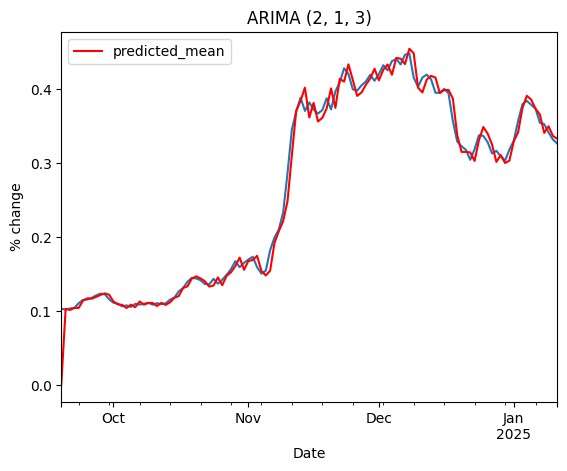

In [ ]:
#Auto Arima
AUTO_ARIMA_02 = auto_arima(dados_02_ns,
                       start_p=1, start_q=1,
                       max_p=3, max_q=3,
                       seasonal=False,
                       d=1,
                       trace=True,
                       error_action='trace',
                       suppress_warnings=True,
                       stepwise=False)

print(AUTO_ARIMA_02.params())

best_model_02 = AUTO_ARIMA_02
best_order_02 = best_model_02.order

# Melhor modelo ARIMA(best_order_02)
BEST_ARIMA_adf_dados_02_ns = ARIMA(dados_02_ns, order=(best_order_02))
res_BEST_ARIMA_adf_dados_02_ns = BEST_ARIMA_adf_dados_02_ns.fit()
print(res_BEST_ARIMA_adf_dados_02_ns.summary())
BEST_ARIMA_adf_dados_02_ns_predict = pd.DataFrame(res_BEST_ARIMA_adf_dados_02_ns.predict())
fig, ax = py.subplots(1, 1)
dados_02_ns.plot(ax=ax)
BEST_ARIMA_adf_dados_02_ns_predict.plot(ax=ax,color='red')
py.ylabel("% change"); py.title('ARIMA '+str(best_order_02));
py.show()

     lb_stat  lb_pvalue
10  6.035025   0.812312


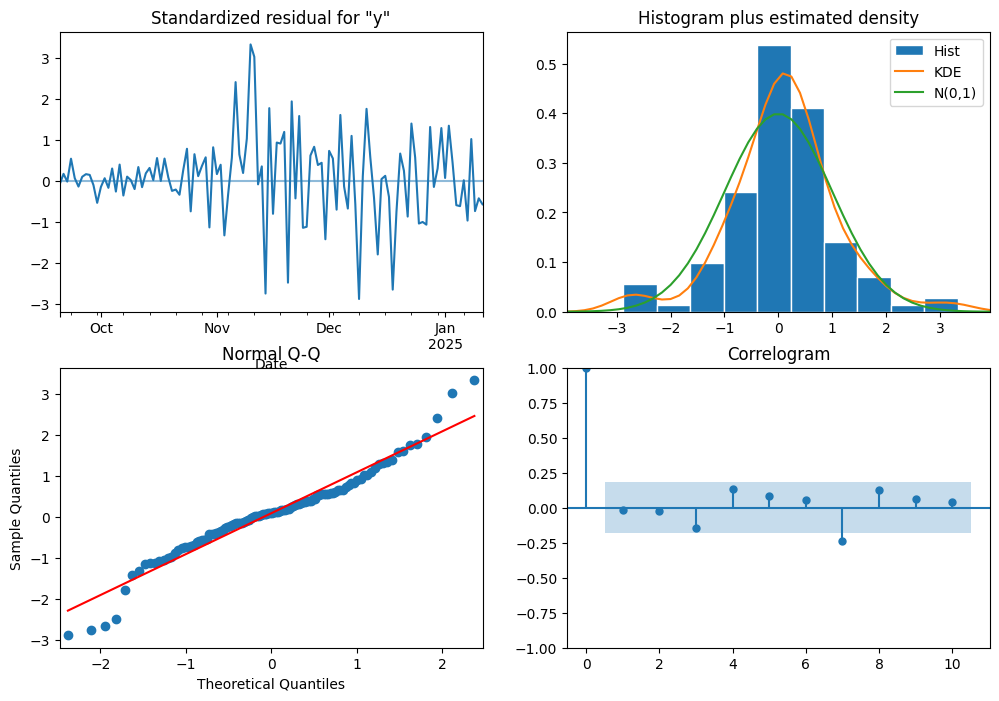

In [ ]:
# Analise dos resíduos
AUX = acorr_ljungbox(res_BEST_ARIMA_adf_dados_02_ns.resid, lags=[10])
res_BEST_ARIMA_adf_dados_02_ns.plot_diagnostics(figsize=(12,8))
print(AUX)
py.show()

In [ ]:
indice_10_frente_temp_02 = pd.date_range(dados_02_ns.index[-1], freq="D", periods = 10+1) #Índice temporal para as previsões
indice_10_frente_02 = indice_10_frente_temp_02[1:]
fcast_BEST_ARIMA_dados_02 = res_BEST_ARIMA_adf_dados_02_ns.get_forecast(10)
fcast_BEST_ARIMA_dados_02_mean = fcast_BEST_ARIMA_dados_02.summary_frame(alpha=0.05)['mean']
fcast_BEST_ARIMA_dados_02_low = fcast_BEST_ARIMA_dados_02.summary_frame(alpha=0.05)['mean_ci_lower']
fcast_BEST_ARIMA_dados_02_up = fcast_BEST_ARIMA_dados_02.summary_frame(alpha=0.05)['mean_ci_upper']
fcast_BEST_ARIMA_dados_02_mean = fcast_BEST_ARIMA_dados_02_mean.rename('ARIMA Forecast ' + str(best_order))

Forecast ARMA  (0, 1, 0) :
 y               mean   mean_se  mean_ci_lower  mean_ci_upper
2025-01-12  0.326886  0.011464       0.304418       0.349355
2025-01-13  0.328144  0.020031       0.288884       0.367404
2025-01-14  0.326792  0.027468       0.272956       0.380628
2025-01-15  0.324026  0.035186       0.255062       0.392989
2025-01-16  0.321422  0.042801       0.237533       0.405311
2025-01-17  0.320135  0.049581       0.222958       0.417311
2025-01-18  0.320460  0.055102       0.212462       0.428458
2025-01-19  0.321894  0.059417       0.205439       0.438348
2025-01-20  0.323534  0.062886       0.200281       0.446788
2025-01-21  0.324587  0.065946       0.195335       0.453839 



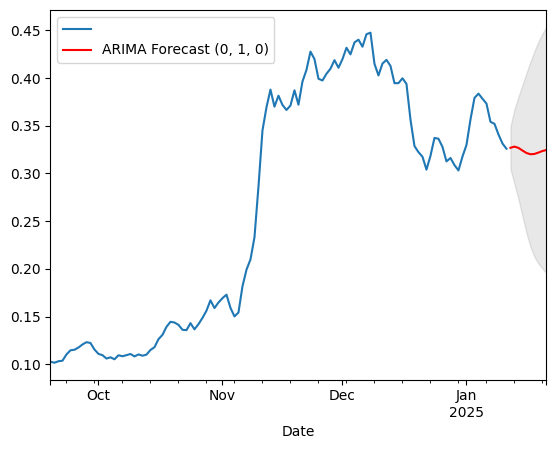

In [ ]:
## Imprime as previsões
print(f'Forecast ARMA ',best_order, ':\n',fcast_BEST_ARIMA_dados_02.summary_frame(alpha=0.05),'\n')

## Gráfico das previsões
fig_, ax_ = py.subplots(1, 1)
dados_02_ns.plot(ax=ax_, legend=True)
fcast_BEST_ARIMA_dados_02_mean.plot(ax=ax_,color='red', legend=True)
ax_.fill_between(indice_10_frente, fcast_BEST_ARIMA_dados_02_low, fcast_BEST_ARIMA_dados_02_up, color='k',alpha=.09);
py.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -354.707
Distribution:                  Normal   AIC:                           717.415
Method:            Maximum Likelihood   BIC:                           728.394
                                        No. Observations:                  115
Date:                Mon, Jan 13 2025   Df Residuals:                      114
Time:                        04:30:27   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2479      0.573      0.433      0.665 [ -0.875,  1.37

<bound method NDFrame.head of Date
2024-09-19    0.051968
2024-09-20    0.044079
2024-09-21    0.043433
2024-09-22    0.050982
2024-09-23    0.049883
                ...   
2025-01-07    0.044095
2025-01-08    0.085289
2025-01-09    0.045506
2025-01-10    0.062277
2025-01-11    0.050103
Freq: D, Name: cond_vol, Length: 115, dtype: float64>

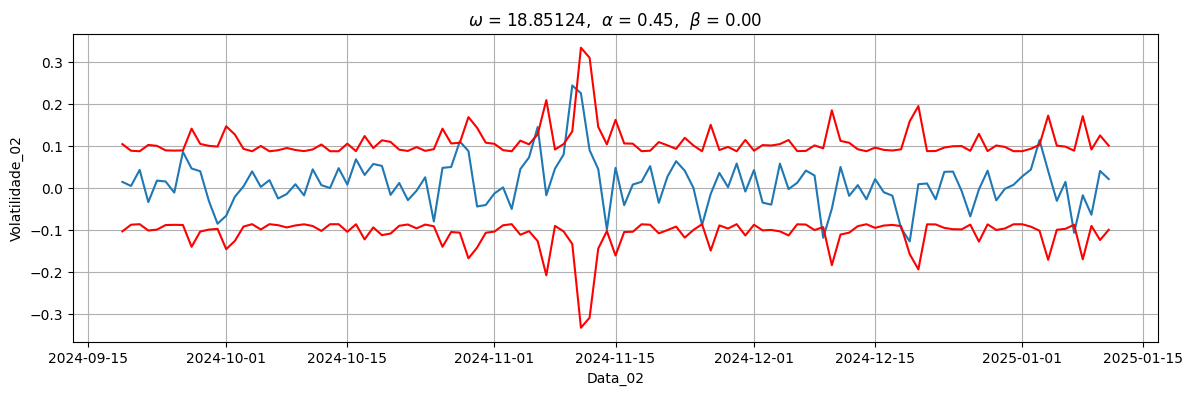

In [ ]:
#GARCH (1,1)
from arch import arch_model

dados_02_2 = dados_02['Return'].dropna()
garch_1_1_02 = arch_model(100*dados_02_2, p=1, q=1, mean='constant', vol='GARCH', dist='normal')
garch_1_1_results_02 = garch_1_1_02.fit(update_freq=0, disp=False)


print(garch_1_1_results_02.summary())
alpha_02 = garch_1_1_results_02.params['alpha[1]']
beta_02  = garch_1_1_results_02.params['beta[1]']
omega_02 = garch_1_1_results_02.params['omega']
py.figure(figsize=(14, 4))
py.plot(dados_02_2, label='Retorno')
py.plot( 2*garch_1_1_results_02.conditional_volatility/100, 'r', label='$\pm 2\sigma$')
py.plot(-2*garch_1_1_results_02.conditional_volatility/100, 'r')

py.title('$\omega$ = {:.5f},  $\\alpha$ = {:.2f},  $\\beta$ = {:.2f}'.format(omega_02, alpha_02, beta_02))
py.grid(True)
py.xlabel('Data_02')
py.ylabel('Volatilidade_02')
dados_02_2['VolGARCH(1,1)_02'] = garch_1_1_results_02.conditional_volatility/100
dados_02_2['VolGARCH(1,1)_02'].head

<bound method NDFrame.head of                    0
time                
2025-01-12  0.255006
2025-01-13  0.255006
2025-01-14  0.255006
2025-01-15  0.255006
2025-01-16  0.255006
...              ...
2025-04-17  0.255006
2025-04-18  0.255006
2025-04-19  0.255006
2025-04-20  0.255006
2025-04-21  0.255006

[100 rows x 1 columns]>


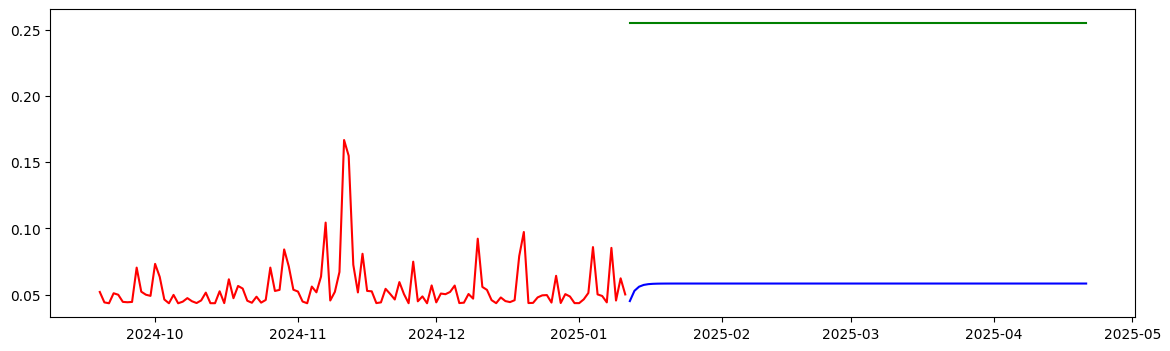

In [ ]:
#GARCH(1,1)

vol_garch_1_1_02 = garch_1_1_results_02.conditional_volatility/100
forecast_garch_1_1_02 = garch_1_1_results_02.forecast(horizon=100, reindex=False)
garch_1_1_vol_forecast_np_02 = np.sqrt(forecast_garch_1_1_02.variance.values)/100
garch_1_1_vol_forecast_02 = pd.DataFrame(np.transpose(garch_1_1_vol_forecast_np_02))
py.figure(figsize=(14, 4))
py.plot( vol_garch_1_1_02, 'r')
idx_frente_temp_02 = pd.date_range(vol_garch_1_1_02.index[-1], freq="D", periods = 100+1) #Índice temporal para as previsões
idx_frente_02 = idx_frente_temp_02[1:]
garch_1_1_vol_forecast_02['time'] = idx_frente_02
garch_1_1_vol_forecast_02 = garch_1_1_vol_forecast_02.set_index('time') #Cría índice temporal
py.plot(garch_1_1_vol_forecast_02, 'b')
alpha_02 = garch_1_1_results_02.params['alpha[1]']
beta_02  = garch_1_1_results_02.params['beta[1]']
omega_02 = garch_1_1_results_02.params['omega']
var_garch_1_1_02= omega_02/(1-(alpha + beta))
std_garch_1_1_02 = pd.DataFrame(np.repeat(np.sqrt(var_garch_1_1_02)/100,100))
std_garch_1_1_02['time'] = idx_frente_02
std_garch_1_1_02 = std_garch_1_1_02.set_index('time') #Cría índice temporal
py.plot(std_garch_1_1_02, 'g')
print(std_garch_1_1_02.head)

In [ ]:
#######################################################################################################################################################################################################################################################

In [ ]:
#######################################################################################################################################################################################################################################################

##Correlação

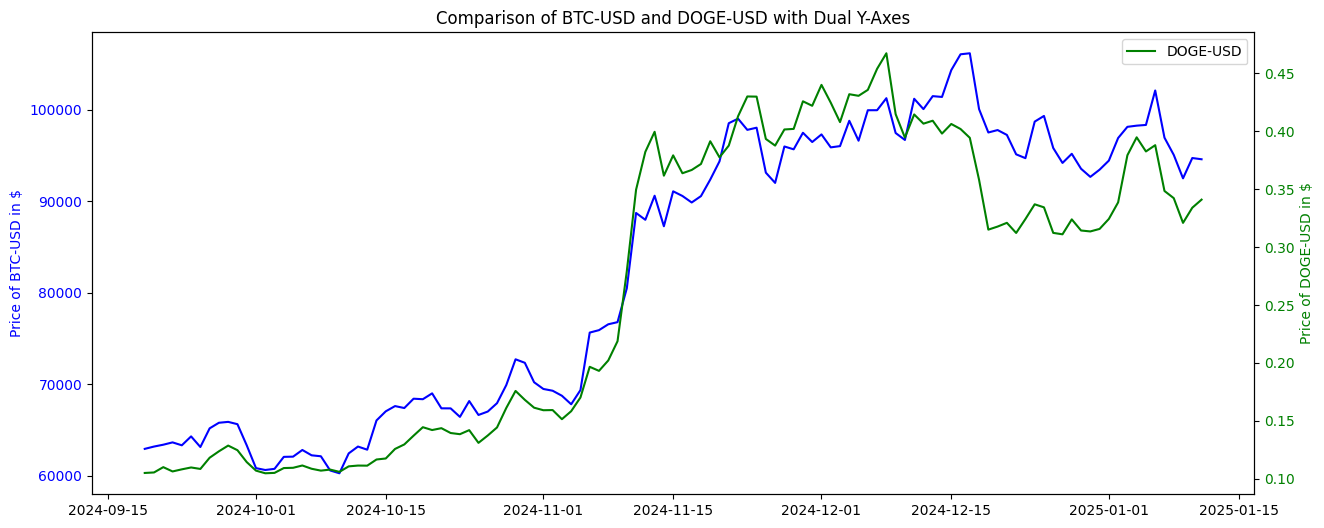

In [ ]:
# Encontrar o intervalo de datas comum
data_inicio_comum = max(dados_01.index.min(), dados_02.index.min())
data_fim_comum = min(dados_01.index.max(), dados_02.index.max())

# Filtrar os dados para o intervalo comum
dados_01_filtrados = dados_01[(dados_01.index >= data_inicio_comum) & (dados_01.index <= data_fim_comum)]
dados_02_filtrados = dados_02[(dados_02.index >= data_inicio_comum) & (dados_02.index <= data_fim_comum)]

# Plotagem
py.figure(figsize=(15, 6))
py.plot(dados_01_filtrados.index, dados_01_filtrados['Adj Close'], label=ticket_01, color='blue')
py.ylabel(f'Price of {ticket_01} in $', color='blue')
py.tick_params(axis='y', labelcolor='blue')

ax2 = py.gca().twinx()
ax2.plot(dados_02_filtrados.index, dados_02_filtrados['Adj Close'], label=ticket_02, color='green')  # Supondo 'Close' como a coluna relevante
ax2.set_ylabel(f'Price of {ticket_02} in $', color='green')
ax2.tick_params(axis='y', labelcolor='green')

py.legend(loc='upper left')
ax2.legend(loc='upper right')

py.title(f'Comparison of {ticket_01} and {ticket_02} with Dual Y-Axes')
py.show()

In [ ]:
#Regressão Linear
# Merge on dates to ensure alignment
merged_data = pd.merge(dados_01, dados_02, on='Date', how='inner')
merged_data.dropna()

retorno_01 = merged_data['Return_x'].reset_index(drop=True)
retorno_02 = merged_data['Return_y'].reset_index(drop=True)

retorno_01 = retorno_01.fillna(retorno_01.mean())
retorno_02 = retorno_02.fillna(retorno_02.mean())

# Regression model
x = sm.add_constant(retorno_01)
modelo = sm.OLS(retorno_02, x)
resultado = modelo.fit()
print(resultado.summary())
print(f"Intercepto = ", resultado.params[0],", Coeficiente = ", resultado.params[1])

                            OLS Regression Results                            
Dep. Variable:               Return_y   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     159.3
Date:                Mon, 13 Jan 2025   Prob (F-statistic):           2.55e-23
Time:                        04:30:28   Log-Likelihood:                 217.00
No. Observations:                 115   AIC:                            -430.0
Df Residuals:                     113   BIC:                            -424.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.094      0.2

<ipython-input-38-64186edd2ec3>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Intercepto = ", resultado.params[0],", Coeficiente = ", resultado.params[1])


In [ ]:
# Correlação
# Alinhando os dados por data
dados_alinhados = pd.merge(dados_01[['Return']], dados_02[['Return']], left_index=True, right_index=True, suffixes=('_01', '_02'))

# Calculando a correlação de Pearson
correlacao_pearson = dados_alinhados.corr()

print(correlacao_pearson)

Price            Return_01 Return_02
Ticker                              
Price     Ticker                    
Return_01         1.000000  0.764865
Return_02         0.764865  1.000000


In [ ]:
# Supondo que 'Return' é uma coluna nos DataFrames dados_01 e dados_02
R_x = np.array(dados_01['Return'])
R_y = np.array(dados_02['Return'])

# Verifique se ambos os arrays têm o mesmo comprimento
if len(R_x) != len(R_y):
    raise ValueError("Os arrays R_x e R_y devem ter o mesmo comprimento")

# Calculando a média
r_x = np.mean(R_x)
r_y = np.mean(R_y)

# Calculando as distâncias em relação à média
dis_x = R_x - r_x
dis_y = R_y - r_y

# Calculando o numerador da correlação (covariância não normalizada)
numerador = np.sum(dis_x * dis_y)

# Calculando os denominadores
den_x = np.sqrt(np.sum(dis_x ** 2))
den_y = np.sqrt(np.sum(dis_y ** 2))

# Correlação de Pearson entre R_x e R_y
correlacao = numerador / (den_x * den_y)

print("Correlação entre R_x e R_y:", correlacao)


Correlação entre R_x e R_y: 0.7648648947388101


In [ ]:
# Supondo que 'Return' é uma coluna nos DataFrames dados_01 e dados_02
R_x = np.array(dados_01['Return'])
R_y = np.array(dados_02['Return'])

# Verifique se ambos os arrays têm o mesmo comprimento
n = len(R_x)
if n != len(R_y):
    raise ValueError("Os arrays R_x e R_y devem ter o mesmo comprimento")

# Calculando a média
r_x = np.mean(R_x)
r_y = np.mean(R_y)

# Calculando as distâncias em relação à média
dis_x = R_x - r_x
dis_y = R_y - r_y

# Calculando a covariância entre R_x e R_y
cov_xy = np.sum(dis_x * dis_y) / (n - 1)

# Calculando a variância de R_x e R_y
var_x = np.sum(dis_x ** 2) / (n - 1)
var_y = np.sum(dis_y ** 2) / (n - 1)

# Construindo a matriz de covariância manualmente
cov_matrix = np.array([[var_x, cov_xy], [cov_xy, var_y]])

print("Matriz de Covariância entre R_x e R_y:")
print(cov_matrix)

print("Matriz de desvio padrão entre R_x e R_y:")
print(np.sqrt(cov_matrix))

Matriz de Covariância entre R_x e R_y:
[[0.00061812 0.00108713]
 [0.00108713 0.0032683 ]]
Matriz de desvio padrão entre R_x e R_y:
[[0.02486207 0.03297171]
 [0.03297171 0.05716903]]


In [ ]:
# Supondo que 'Return' é uma coluna nos DataFrames dados_01 e dados_02
R_x = np.array(dados_01['Return'])
R_y = np.array(dados_02['Return'])

# Verifique se ambos os arrays têm o mesmo comprimento
n = len(R_x)
if n != len(R_y):
    raise ValueError("Os arrays R_x e R_y devem ter o mesmo comprimento")

# Calculando a média
r_x = np.mean(R_x)
r_y = np.mean(R_y)

# Calculando as distâncias em relação à média
dis_x = R_x - r_x
dis_y = R_y - r_y

dis = np.array([dis_x,dis_y])

# Calculando a covariância entre R_x e R_y
cov_matrix2 = np.dot(dis, dis.T) / (n - 1)

print("Matriz de Covariância entre R_x e R_y:")
print(cov_matrix2)

Matriz de Covariância entre R_x e R_y:
[[0.00061812 0.00108713]
 [0.00108713 0.0032683 ]]


In [ ]:
dados_alinhados.cov()

,Price,Return_01,Return_02
,Ticker,,
Price,Ticker,,
Return_01,,0.000618,0.001087
Return_02,,0.001087,0.003268
